# Monte Carlo Simulation for Portfolio development

This notebook focuses on the use of Monte Carlo Simulation in valuing financial derivatives.

----

In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import scipy.stats as stats
from pandas_datareader import data as pdr
import yfinance as yf

Fetch data

In [31]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=300)

In [32]:
googl = yf.download('GOOGL', start=start_date, end=end_date)
aapl = yf.download('AAPL', start=start_date, end=end_date)
msft = yf.download('MSFT', start=start_date, end=end_date)
amzn = yf.download('AMZN', start=start_date, end=end_date)
tsla = yf.download('TSLA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [33]:
df = pd.concat([googl['Close'], aapl['Close'], msft['Close'], amzn['Close'], tsla['Close']], axis=1)
df

Ticker,GOOGL,AAPL,MSFT,AMZN,TSLA
Date,,,,,
2024-01-24 00:00:00+00:00,148.699997,194.500000,402.559998,156.869995,207.830002
2024-01-25 00:00:00+00:00,151.869995,194.169998,404.869995,157.750000,182.630005
2024-01-26 00:00:00+00:00,152.190002,192.419998,403.929993,159.119995,183.250000
2024-01-29 00:00:00+00:00,153.509995,191.729996,409.720001,161.259995,190.929993
2024-01-30 00:00:00+00:00,151.460007,188.039993,408.589996,159.000000,191.589996
...,...,...,...,...,...
2024-11-13 00:00:00+00:00,178.880005,225.119995,425.200012,214.100006,330.239990
2024-11-14 00:00:00+00:00,175.580002,228.220001,426.890015,211.479996,311.179993
2024-11-15 00:00:00+00:00,172.490005,225.000000,415.000000,202.610001,320.720001


In [34]:
meanReturns = df.pct_change().mean()
covMatrix = df.pct_change().cov()
meanReturns

,0
Ticker,
GOOGL,0.000976
AAPL,0.000898
MSFT,0.000209
AMZN,0.001406
TSLA,0.003275


Now we want to define the weights for the portfolio. These weights were determined using a separate notebook, where I calculated the optimal weights along the efficient frontier.

In [35]:
weights = [0.00087784, 0.57222211, 0.16875112, 0.15750551, 0.10064342]
sum(weights)

1.0

## Monte Carlo Simulation

We use the Cholesky decomposition to transform uncorrelated samples from a normal distribution into correlated samples that match the covariance structure of the assets in the portfolio. This allows us to simulate realistic asset price paths that respect the observed correlations between the assets.

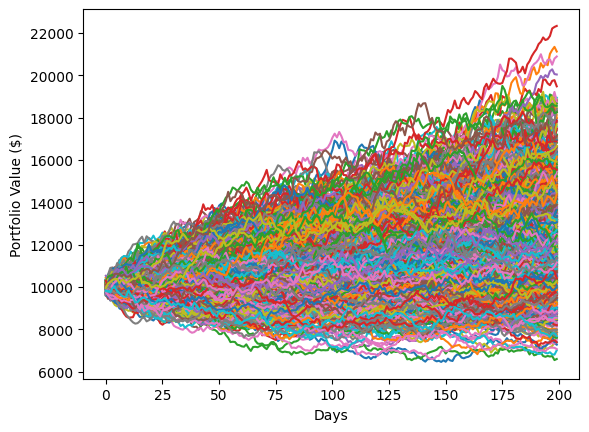

In [38]:
mc_simulations = 1000
T = 200

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_simulations), fill_value=0.0)

intialPortfolio = 10000

for i in range(mc_simulations):
  Z = np.random.normal(size=(T, len(weights)))
  L = np.linalg.cholesky(covMatrix)
  dailyReturns = meanM + np.inner(L, Z)
  portfolio_sims[:, i] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * intialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.show()


<ipython-input-39-292ff80b9d9a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", mc_simulations)


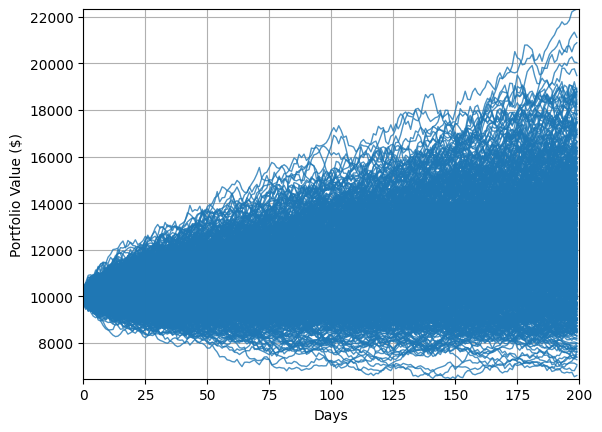

In [39]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_ylim(portfolio_sims.min(), portfolio_sims.max())
ax.set_xlim(0, T)
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Value ($)')
ax.grid()

cmap = plt.cm.get_cmap("tab20", mc_simulations)
colors = [cmap(i % 20) for i in range(mc_simulations)]

x = np.arange(T)
lines = []

def animate(i):
    line, = ax.plot(x, portfolio_sims[:, i], color=colors[i % 20], lw=1, alpha=0.8)
    lines.append(line)
    return lines


ani = animation.FuncAnimation(fig, animate, frames=mc_simulations, interval=20, blit=False)
ani.save('portfolio_simulation_colored.gif', writer='imagemagick', fps=30)

plt.show()

<ipython-input-40-b74d98b4673b>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", mc_simulations)  # Choose a colormap


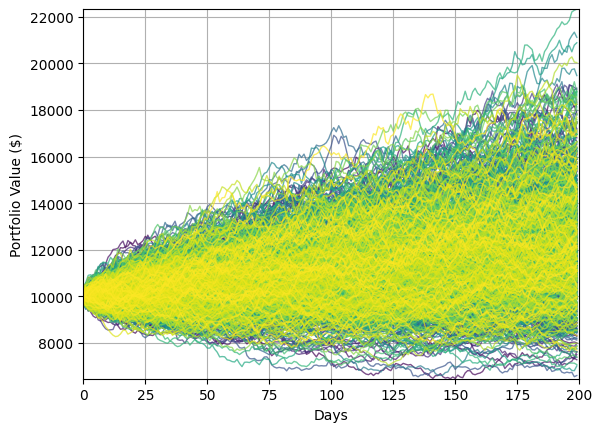

In [40]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots()
ax.set_ylim(portfolio_sims.min(), portfolio_sims.max())
ax.set_xlim(0, T)
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Value ($)')
ax.grid()

# Set up a colormap
cmap = plt.cm.get_cmap("viridis", mc_simulations)  # Choose a colormap
colors = [cmap(i) for i in range(mc_simulations)]  # Generate a list of colors

x = np.arange(T)
lines = []  # Store line objects

# Animation function
def animate(i):
    # Plot a new line for each frame
    line, = ax.plot(x, portfolio_sims[:, i], color=colors[i], lw=1, alpha=0.7)
    lines.append(line)  # Append the new line to the list of lines
    return lines

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=mc_simulations, interval=20, blit=False)

# Save the animation as a GIF (optional)
ani.save('portfolio_simulation_incremental.gif', writer='imagemagick', fps=30)

plt.show()